라이브러리, 데이터로드

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('C:/Users/js351/OneDrive/바탕 화면/고비어W13/online_retail.csv')


데이터 전처리

In [ ]:
data = data.dropna(subset=['CustomerID'])

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['TotalRevenue'] = data['Quantity'] * data['UnitPrice']

data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

data['CohortMonth'] = data.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
data['InvoiceMonth'] = data['InvoiceDate'].dt.to_period('M')

data['CohortIndex'] = (
    data['InvoiceMonth'].dt.to_timestamp() - data['CohortMonth'].dt.to_timestamp()
).apply(lambda x: x.days // 30)

data = data[
    (data['UnitPrice'] < 100) &
    (data['TotalRevenue'] < data['TotalRevenue'].quantile(0.99))
]


Cohort 분석

In [ ]:
cohort_data = data.groupby(['CohortMonth', 'CohortIndex']).agg({
    'CustomerID': 'nunique',  # 고유 고객 수
    'TotalRevenue': 'sum',    # 총 매출
    'InvoiceNo': 'nunique'    # 총 주문 수
}).rename(columns={
    'CustomerID': 'TotalCustomers',
    'TotalRevenue': 'TotalRevenue',
    'InvoiceNo': 'TotalOrders'
}).reset_index()


cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='TotalCustomers')
retention_rate = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0)


Retention Rate Heatmap

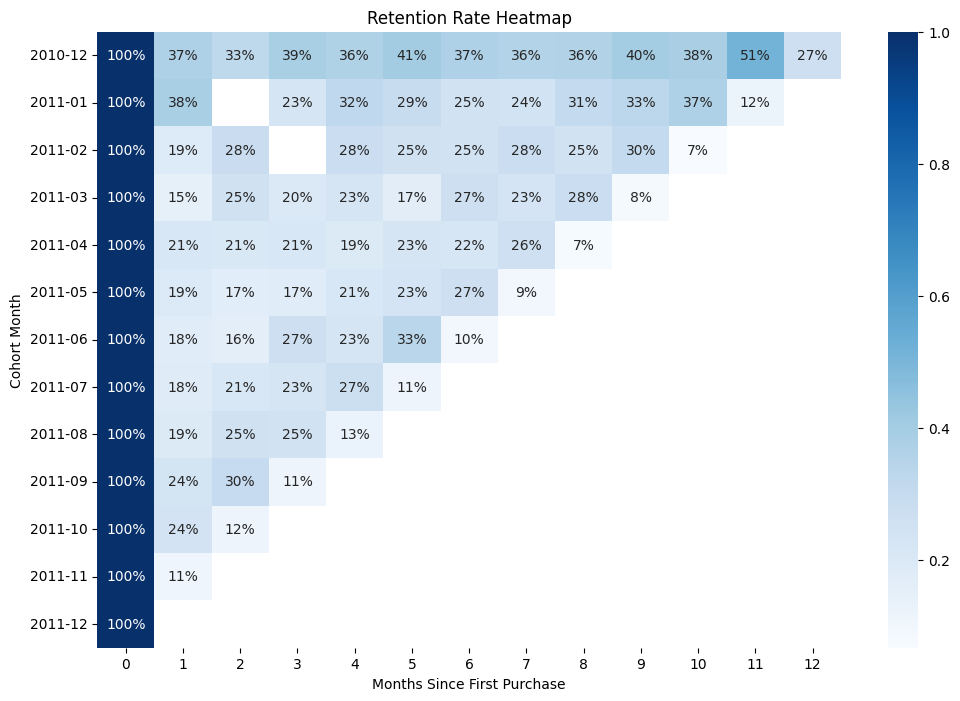

In [4]:
plt.figure(figsize=(12, 8))
sns.heatmap(retention_rate, annot=True, fmt='.0%', cmap='Blues')
plt.title('Retention Rate Heatmap')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.show()

Average Order Value 변화

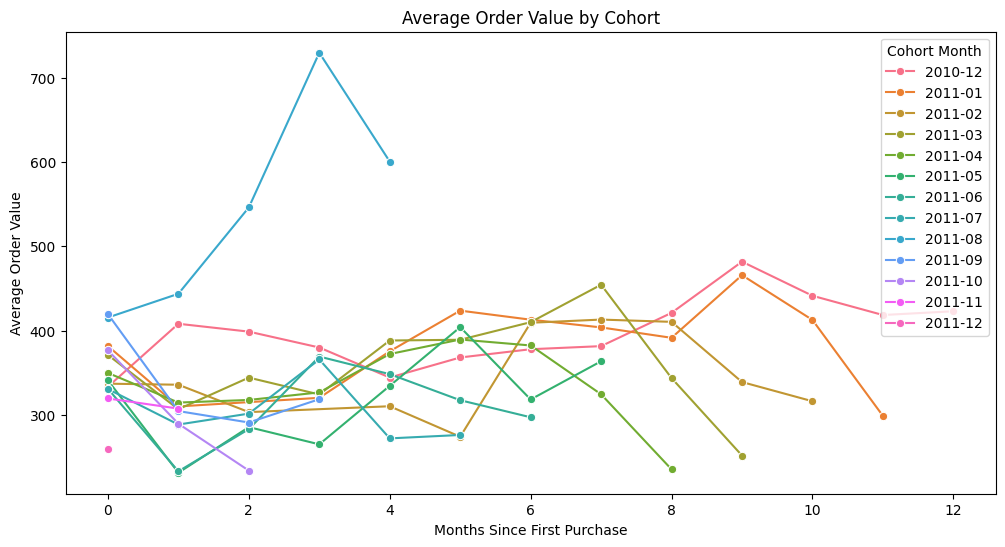

In [ ]:
cohort_data['AOV'] = cohort_data['TotalRevenue'] / cohort_data['TotalOrders']
cohort_data['Frequency'] = cohort_data['TotalOrders'] / cohort_data['TotalCustomers']

plt.figure(figsize=(12, 6))
sns.lineplot(data=cohort_data, x='CohortIndex', y='AOV', hue='CohortMonth', marker='o')
plt.title('Average Order Value by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Average Order Value')
plt.legend(title='Cohort Month')
plt.show()


월별 Cohort 총 매출

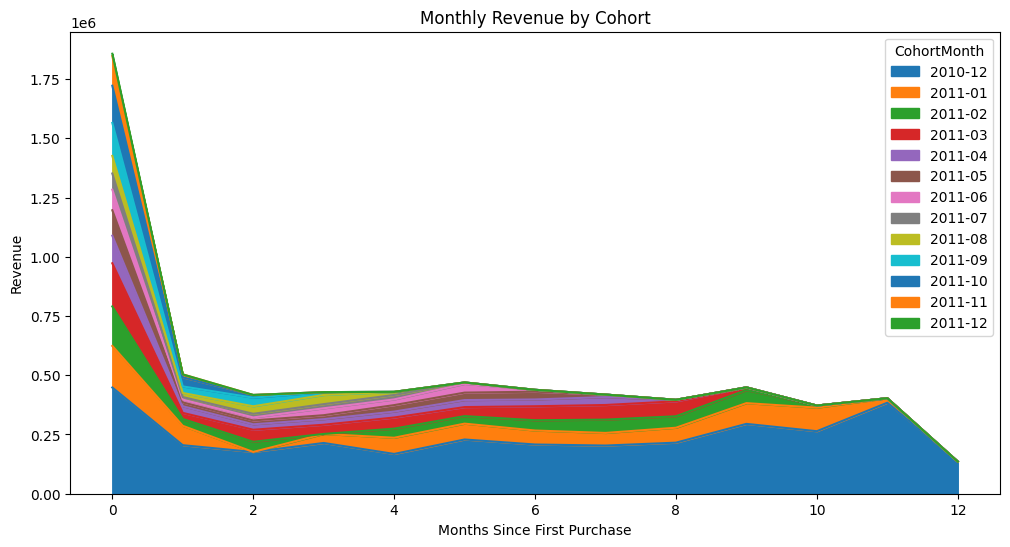

In [6]:
revenue_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='TotalRevenue')
revenue_pivot.T.plot(kind='area', figsize=(12, 6), stacked=True)
plt.title('Monthly Revenue by Cohort')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Revenue')
plt.show()


클러스터링 데이터 준비 및 표준화

In [7]:
cohort_features = cohort_data[['TotalRevenue', 'AOV', 'Frequency']].fillna(0)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cohort_features)


K-Means 클러스터링 

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
cohort_data['Cluster'] = kmeans.fit_predict(scaled_features)


클러스터 시각화

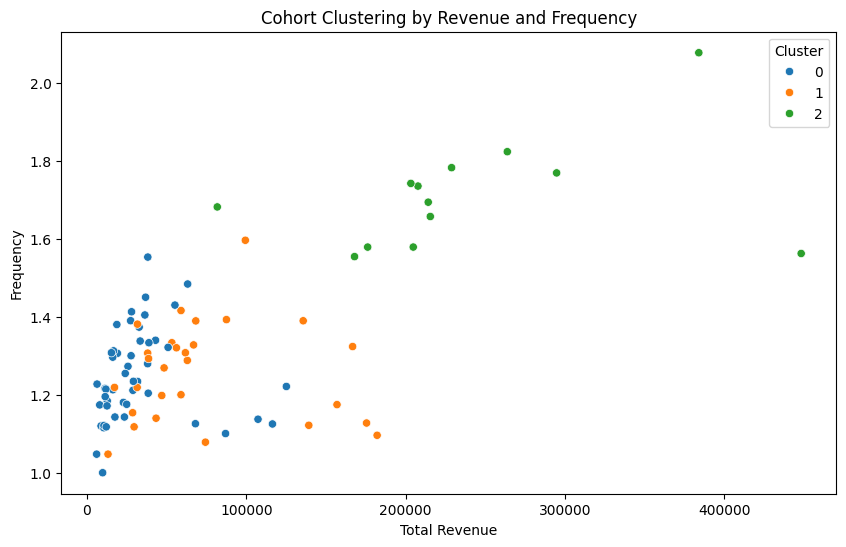

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cohort_data, x='TotalRevenue', y='Frequency', hue='Cluster', palette='tab10')
plt.title('Cohort Clustering by Revenue and Frequency')
plt.xlabel('Total Revenue')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()
